In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import spacy

import nltk
import ssl
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

from gensim.models import Word2Vec
from gensim.models import FastText

from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_curve, precision_recall_curve, auc

import warnings
warnings.filterwarnings("ignore")


In [4]:
df_spam = pd.read_csv('datasets/spam_or_not_spam.csv')
df_spam.head()

,email,label
0,date wed NUMBER aug NUMBER NUMBER NUMBER NUMB...,0
1,martin a posted tassos papadopoulos the greek ...,0
2,man threatens explosion in moscow thursday aug...,0
3,klez the virus that won t die already the most...,0
4,in adding cream to spaghetti carbonara which ...,0


Препроцессинг текста

In [ ]:
!python -m spacy download en_core_web_sm

In [6]:
nlp = spacy.load("en_core_web_sm")
stopwords = nlp.Defaults.stop_words

In [7]:
%%time
df_spam['email'] = df_spam['email'].astype(str)
df_spam['cleaned_text'] = df_spam['email'].apply(
    lambda x: ' '.join(
        token.lemma_.lower() for token in nlp(x) if
        not token.is_stop
        and not token.is_punct
        and not token.is_digit
        and not token.like_email
        and not token.like_num
        and not token.is_space
    )
)
df_spam.sample(5)

CPU times: user 2min 2s, sys: 4.49 s, total: 2min 6s
Wall time: 2min 7s


,email,label,cleaned_text
565,URL miami sept NUMBER a two gram rock of crac...,0,url miami sept number gram rock crack cocaine ...
1132,how easy would it be to code a menu item that...,0,easy code menu item mark read message current ...
914,chris haun wrote a lifegem is a certified high...,0,chris haun write lifegem certify high quality ...
2548,me and my friends have this brand new idea a l...,1,friend brand new idea live webcam hyperlink cl...
1085,once upon a time peter wrote i started wonderi...,0,time peter write start wonder apt react find n...


In [ ]:
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('punkt')
nltk.download('stopwords')

In [9]:
tokenized_texts = []

for text in df_spam['cleaned_text']:
    tokens = word_tokenize(text)
    filtered_tokens = [token for token in tokens if token not in stopwords]
    tokenized_texts.append(filtered_tokens)

In [10]:
X_token_train, X_token_test, y_train, y_test = train_test_split(tokenized_texts,
                                                    df_spam['label'], 
                                                    test_size=0.2,
                                                    random_state=2023)

Word2Vec

In [11]:
#skipgram
model_skipgram = Word2Vec(
    sentences=X_token_train,
    vector_size=256, # default = 100
    window=7, # default = 5
    min_count=10,
    sg=1, # Training algorithm: 1 for skip-gram; otherwise CBOW
    hs=0, #  If 1, hierarchical softmax will be used for model training. If 0, and negative is non-zero, negative sampling will be used.
    negative=5, # If > 0, negative sampling will be used, if set to 0, no negative sampling is used.
    epochs=25, # Number of iterations (epochs) over the corpus
    seed=2023,
)

In [12]:
#CBOW
model_cbow = Word2Vec(
    sentences=X_token_train,
    vector_size=256, # default = 100
    window=7, # default = 5
    min_count=10,
    sg=0, # Training algorithm: 1 for skip-gram; otherwise CBOW
    hs=0, #  If 1, hierarchical softmax will be used for model training. If 0, and negative is non-zero, negative sampling will be used.
    negative=5, # If > 0, negative sampling will be used, if set to 0, no negative sampling is used.
    epochs=25, # Number of iterations (epochs) over the corpus
    seed=2023,
)

FastText

In [13]:
model_fasttext = FastText(
    sentences=X_token_train,
    vector_size=256,  # Размерность векторов слов
    window=7,  # Максимальное расстояние между центральным словом и контекстными словами
    min_count=10,  # Минимальная частота слова в корпусе
    sg=0,  # CBOW: 0, Skip-gram: 1
    hs=0,  # Использовать ли иерархический софтмакс
    negative=5,  # Количество негативных примеров для negative sampling
    epochs=25,  # Количество эпох обучения
    seed=2023
)

**Сравнение полученных эмеддингов**

In [14]:
tsne = TSNE(n_components=2, perplexity=30, n_iter=300)

vectors_skipgram = model_skipgram.wv.vectors
vectors_cbow = model_cbow.wv.vectors
vectors_fasttext = model_fasttext.wv.vectors

tsne_result_skipgram = tsne.fit_transform(vectors_skipgram)
tsne_result_cbow = tsne.fit_transform(vectors_cbow)
tsne_result_fasttext = tsne.fit_transform(vectors_fasttext)

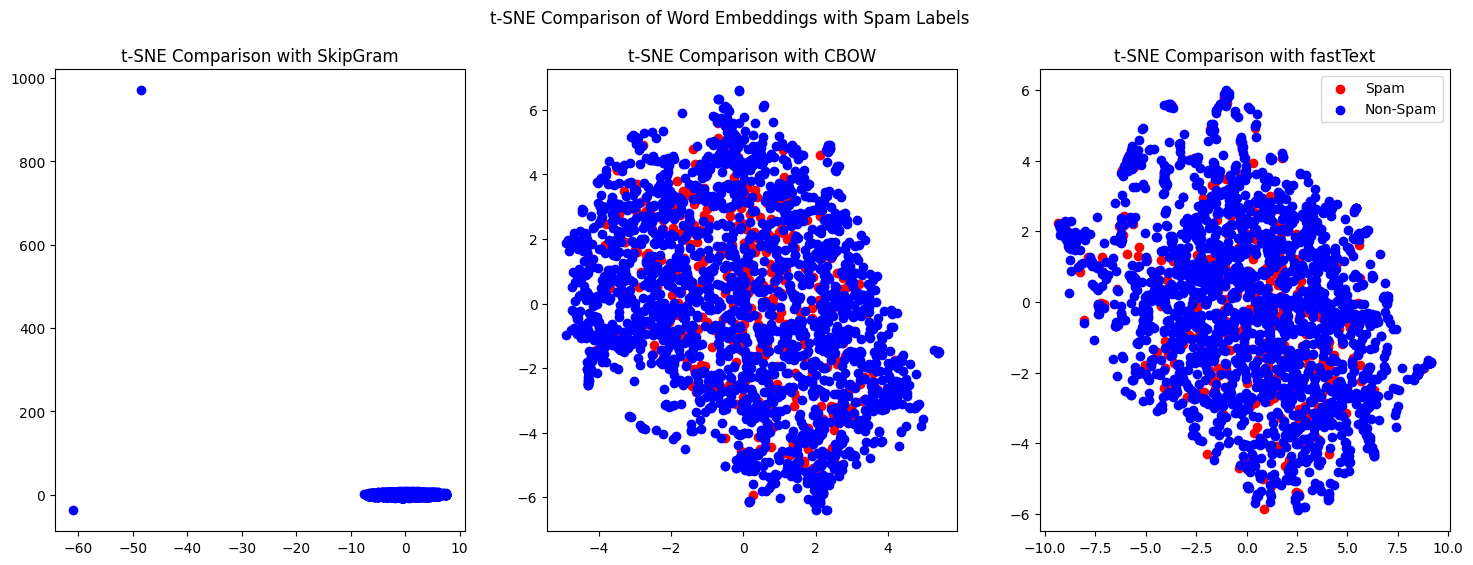

In [15]:
vectors = [tsne_result_skipgram, tsne_result_cbow, tsne_result_fasttext]
labels = ["SkipGram", "CBOW", "fastText"]

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

for i in range(len(vectors)):
    tsne_df = pd.DataFrame(data=vectors[i], columns=['x', 'y'])
    tsne_df['label'] = y_train

    spam_data = tsne_df[tsne_df['label'] == 1]
    non_spam_data = tsne_df[tsne_df['label'] == 0]

    axs[i].scatter(spam_data['x'], spam_data['y'], label='Spam', color='red')
    axs[i].scatter(non_spam_data['x'], non_spam_data['y'], label='Non-Spam', color='blue')
    
    axs[i].set_title(f't-SNE Comparison with {labels[i]}')

plt.suptitle('t-SNE Comparison of Word Embeddings with Spam Labels')
plt.legend()
plt.show()

Похожесть слов

In [16]:
similar_words = model_skipgram.wv.most_similar(positive=["money"], topn=5)
print(similar_words)

[('upfront', 0.4849258363246918), ('eligible', 0.3666616380214691), ('investment', 0.3645436763763428), ('endless', 0.3445489704608917), ('assist', 0.3416942059993744)]


In [17]:
similar_words = model_cbow.wv.most_similar(positive=["money"], topn=5)
print(similar_words)

[('investment', 0.524142324924469), ('upfront', 0.5084758400917053), ('cash', 0.4664595425128937), ('assist', 0.4606616199016571), ('pocket', 0.43699270486831665)]


In [18]:
similar_words = model_fasttext.wv.most_similar(positive=["money"], topn=5)
print(similar_words)

[('monopoly', 0.6965430974960327), ('kearney', 0.6755311489105225), ('investment', 0.5547649264335632), ('cash', 0.5297443270683289), ('disney', 0.5249077081680298)]


Непохожесть слов

In [19]:
odd_word = model_skipgram.wv.doesnt_match(["money", "bank", "cash", "house"])
print(odd_word)

house


In [20]:
odd_word = model_cbow.wv.doesnt_match(["money", "bank", "cash", "house"])
print(odd_word)

house


In [21]:
odd_word = model_fasttext.wv.doesnt_match(["money", "bank", "cash", "house"])
print(odd_word)

house


**Обучение моделей**

W2V Skipgram

In [22]:
def average_word_vectors(words, model, num_features):
    feature_vector = np.zeros((num_features,), dtype="float32")
    nwords = 0

    for word in words:
        if word in model.wv:
            nwords = nwords + 1
            feature_vector = np.add(feature_vector, model.wv[word])

    if nwords:
        feature_vector = np.divide(feature_vector, nwords)

    return feature_vector

In [23]:
X_train = [average_word_vectors(text, model_skipgram, 256) for text in X_token_train]

skipgram_lg = LogisticRegression(random_state=2023)

param_grid_logreg = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2'],
}

search_skipgram = HalvingGridSearchCV(skipgram_lg, param_grid_logreg, cv=2, scoring='accuracy')
search_skipgram.fit(X_train, y_train)
print(f'Best accuracy on train {search_skipgram.best_score_}')
search_skipgram = search_skipgram.best_estimator_

Best accuracy on train 0.98625


CBOW

In [24]:
X_train = [average_word_vectors(text, model_cbow, 256) for text in X_token_train]

cbow_lg = LogisticRegression(random_state=2023)

param_grid_logreg = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2'],
}

search_cbow = HalvingGridSearchCV(cbow_lg, param_grid_logreg, cv=2, scoring='accuracy')
search_cbow.fit(X_train, y_train)
print(f'Best accuracy on train {search_cbow.best_score_}')
search_cbow = search_cbow.best_estimator_

Best accuracy on train 0.9833333333333334


FastText

In [25]:
X_train = [average_word_vectors(text, model_fasttext, 256) for text in X_token_train]


fasttext_lg = LogisticRegression(random_state=2023)

param_grid_logreg = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2'],
}

search_fasttext = HalvingGridSearchCV(fasttext_lg, param_grid_logreg, cv=2, scoring='accuracy')
search_fasttext.fit(X_train, y_train)
print(f'Best accuracy on train {search_fasttext.best_score_}')
search_fasttext = search_fasttext.best_estimator_

Best accuracy on train 0.9820833333333333


In [26]:
def get_test_embeds(X_test, model, max_length: int=256):
    test_embeddings = []

    for text in X_test:
        text_embeddings = []
        for word in text:
            if word in model.wv:
                word_embedding = model.wv[word]
                text_embeddings.append(word_embedding)
        # Заполняем нулями, если длина не достигает максимальной
        while len(text_embeddings) < max_length:
            text_embeddings.append(np.zeros(model.vector_size))
        test_embeddings.append(np.concatenate(text_embeddings, axis=0)[:max_length])  # Ограничиваем максимальной длиной

    return test_embeddings

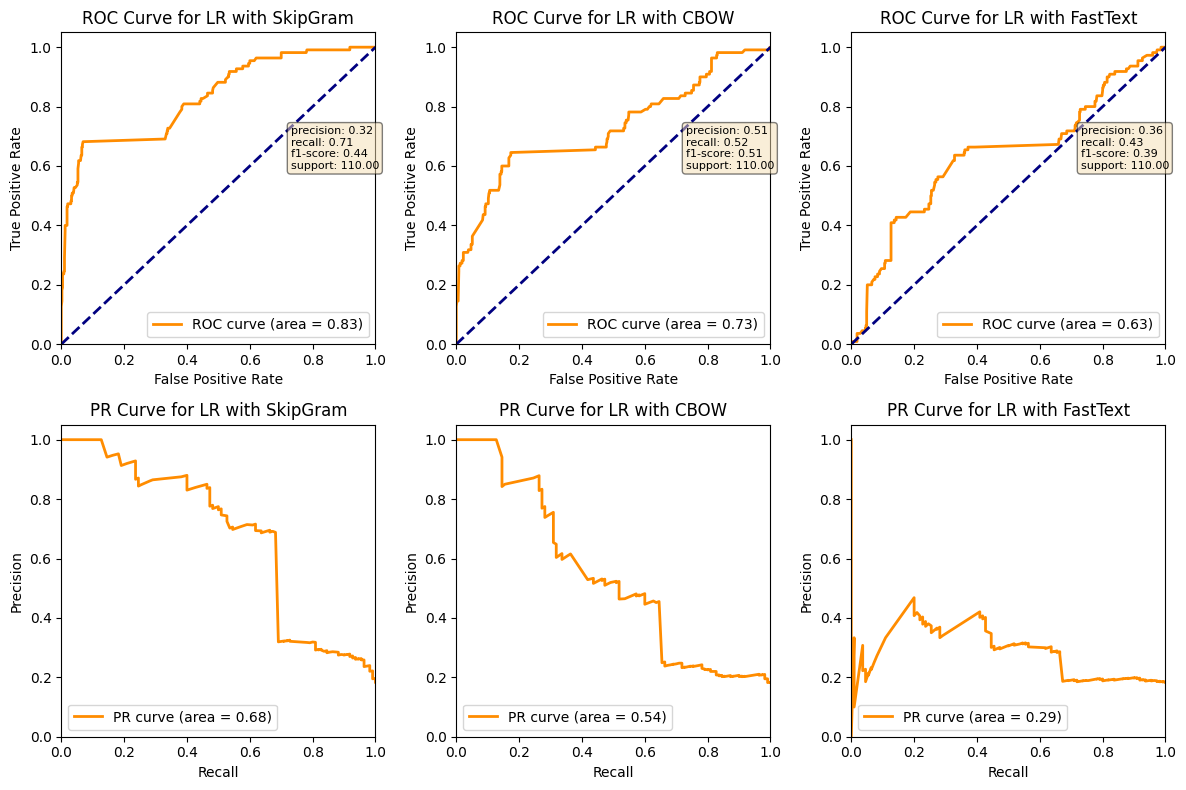

In [27]:
def plot_roc_pr_curves(model, X_token_test, y_test, model_embed, title, ax):

    X_test = get_test_embeds(X_token_test, model_embed)

    y_probas = model.predict_proba(X_test)
    
    # ROC-AUC Curve
    fpr, tpr, thresholds = roc_curve(y_test, y_probas[:, 1])
    roc_auc = auc(fpr, tpr)
    ax[0].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    ax[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax[0].set_xlim([0.0, 1.0])
    ax[0].set_ylim([0.0, 1.05])
    ax[0].set_xlabel('False Positive Rate')
    ax[0].set_ylabel('True Positive Rate')
    ax[0].set_title(f'ROC Curve for {title}')
    ax[0].legend(loc='lower right')

    # PR-AUC Curve
    precision, recall, _ = precision_recall_curve(y_test, y_probas[:, 1])
    pr_auc = auc(recall, precision)
    ax[1].plot(recall, precision, color='darkorange', lw=2, label=f'PR curve (area = {pr_auc:.2f})')
    ax[1].set_xlim([0.0, 1.0])
    ax[1].set_ylim([0.0, 1.05])
    ax[1].set_xlabel('Recall')
    ax[1].set_ylabel('Precision')
    ax[1].set_title(f'PR Curve for {title}')
    ax[1].legend(loc='lower left')

    # Classification Report
    report = classification_report(y_test, model.predict(X_test), output_dict=True)
    textstr = "\n".join([f"{key}: {value:.2f}" for key, value in report['1'].items()])
    ax[0].text(0.73, 0.7, textstr, transform=ax[0].transAxes, fontsize=8, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))


fig, ax = plt.subplots(2, 3, figsize=(12, 8))

plot_roc_pr_curves(search_skipgram, X_token_test, y_test, model_skipgram, "LR with SkipGram", ax[:, 0])
plot_roc_pr_curves(search_cbow, X_token_test, y_test, model_skipgram, "LR with CBOW", ax[:, 1])
plot_roc_pr_curves(search_fasttext, X_token_test, y_test, model_skipgram, "LR with FastText", ax[:, 2])

plt.tight_layout()
plt.show()
